In [384]:
import requests
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

%matplotlib inline

In [385]:
fig_size = [12, 9]
plt.rcParams["figure.figsize"] = fig_size

In [386]:
start_date = 1443571200
end_date = 9999999999
period = 7200 * 12

# data = [{currency_pair: "USDT_BTC"}, {currency_pair: "USDT_ETH"}]

currency_pairs = ["USDT_BTC", "USDT_ETH"]

In [387]:
responses = []
outputs = []
inputs = []


In [388]:
for currency_pair in currency_pairs:
    url = "https://poloniex.com/public?command=returnChartData&currencyPair=" + currency_pair + "&start=" + str(start_date) + "&end=" + str(end_date) + "&period="+ str(period)
    responses.append(requests.get(url).json())

In [389]:
df= pd.DataFrame()
df2 = pd.DataFrame()
df1 = pd.DataFrame()
for x in responses[0]:
    dateprice = pd.DataFrame([datetime.datetime.fromtimestamp(x['date']),x['close']], index=['date', 'btc']).transpose()
    df1 = pd.concat([df1,dateprice])

for x in responses[1]:
    dateprice2 = pd.DataFrame([datetime.datetime.fromtimestamp(x['date']),x['close']], index=['date', 'eth']).transpose()
    df2 = pd.concat([df2,dateprice2])
    
df1['date']=df1['date'].dt.date
df2['date']=df2['date'].dt.date
df1 = df1.set_index('date')
df2 = df2.set_index('date')

In [390]:
df = df1.join(df2)
df = df[df.index > datetime.date(2016, 1, 1)]
# print(df)

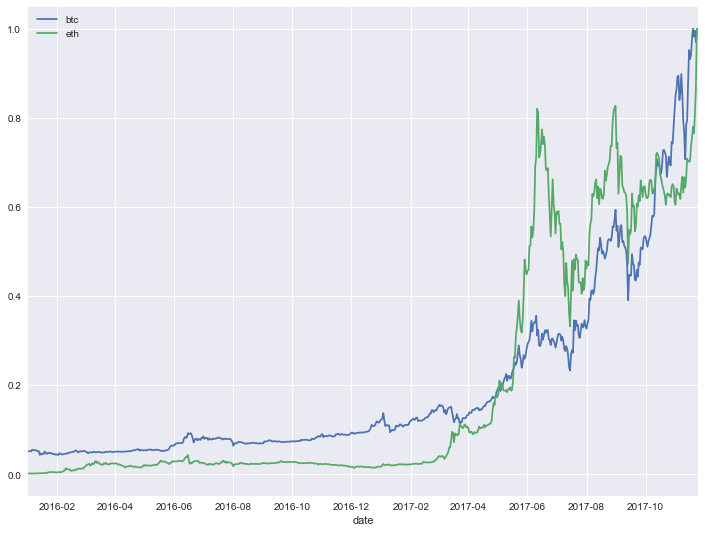

In [391]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

dfnormal = (df/df.max())
dfnormal.plot()

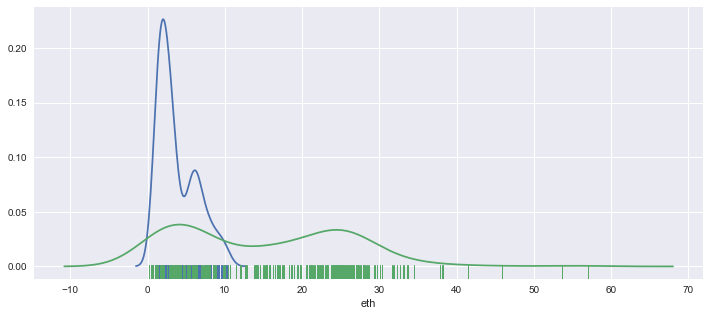

In [392]:
import seaborn as sns
returns = df.pct_change(periods=360)
plt.figure(figsize=(12,5))

returns.dropna(inplace=True)
sns.distplot(returns['btc'],hist=False,rug=True)
sns.distplot(returns['eth'],hist=False,rug=True)

In [393]:
print('RETURNS \n',returns.mean())
print('STANDARD DEVIATION \n',returns.std())

RETURNS 
 btc     3.781172
eth    15.059559
dtype: float64
STANDARD DEVIATION 
 btc     2.462378
eth    11.023682
dtype: float64


In [394]:
returns.corr()

,btc,eth
btc,1.000000,0.862936
eth,0.862936,1.000000


In [395]:
df['year']=pd.to_datetime(df.index).year
pd.to_datetime(df.index).min()

Timestamp('2016-01-02 00:00:00')

In [396]:
for year in df['year'].unique():
    dfyear = df[(df['year']==year)]
    firstday = dfyear[dfyear.index == dfyear.index.min()]
    lastday = dfyear[dfyear.index == dfyear.index.max()]
    
#     for x in firstday:
#         if(x!='year'):
#             print((lastday[x].values-firstday[x].values)/firstday[x].values)


In [251]:
def get_prev_n(index, array, n):
    return array[index - n:index]

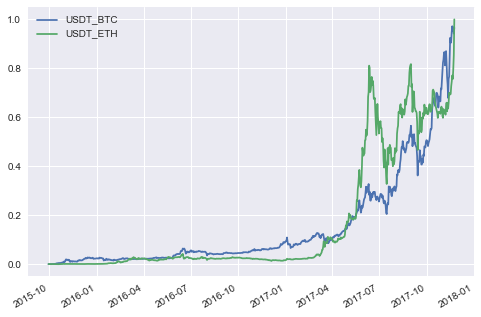

In [240]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%dd')

num_inputs = 20

for i, currency_pair in enumerate(currency_pairs):
    
    r = responses[i]
    closing_prices = np.asarray([item["close"] for item in r])
    normalized_closing_prices = closing_prices/closing_prices.max()
    normalized_closing_prices = normalized_closing_prices - normalized_closing_prices.min()
    ax.plot([datetime.datetime.fromtimestamp(item["date"]) for item in r], normalized_closing_prices, label=currency_pair)
    plt.legend(loc='upper left')
    
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    
    inputs.append([get_prev_n(index, closing_prices, num_inputs) for index, item in enumerate(closing_prices)])

    outputs.append([1 if x > np.mean(np.ediff1d(closing_prices)) else 0 for x in np.ediff1d(closing_prices)])

plt.show()
    

In [8]:
np.corrcoef([x["close"] for x in responses[0]], [x["close"] for x in responses[1]])

array([[ 1.        ,  0.91236509],
       [ 0.91236509,  1.        ]])

In [85]:
from keras.models import Sequential
from keras.layers import Dense

In [92]:
model = Sequential()
model.add(Dense(12, input_dim=num_inputs, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_ = np.asarray(inputs[0][num_inputs + 1:])
Y_ = (outputs[1][num_inputs:])

training_size = len(X_) * 80 // 100
testing_size = len(X_) - training_size

In [93]:
X = X_[num_inputs:training_size]
Y = Y_[num_inputs:training_size]
X_test = X_[training_size:]
Y_test = Y_[training_size:]

In [94]:
model.fit(X, Y, epochs=300 * 2, batch_size=10)

Epoch 1/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 2/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 3/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 4/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 5/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 6/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 7/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 8/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 9/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 10/600
475/475 [==============================] - 0s - loss: 13.5930 - acc: 0.1474     
Epoch 11/600
475/475 [==============================] - 0s - loss: 13

In [95]:
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

 32/124 [======>.......................] - ETA: 0s
acc: 52.42%
